This notebook can be used to extract the area of interest from the original image. In our case, we warped the frames to focus solely on the football field, making it easier to calculate coordinates and compare them with the ground truth drill videos. To isolate the football field, we first needed to detect its corners. We achieved this by employing a state-of-the-art <a href="https://github.com/facebookresearch/segment-anything"> image segmentation model </a> and an off-the-shelf corner detector. Subsequently, we applied standard image warping techniques to transform the original image into a warped version containing only the desired region.

We began by experimenting with the first frame of the video, and after successfully processing it, we applied the same warping process to the remaining frames. Our approach assumes that the area of interest remains consistent across frames within the same video (i.e., the camera and the field did not move), which sufficed for our use case.

### Imports

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamPredictor

/u/h/u/huanga/miniconda3/envs/drone_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### TODO

In [2]:
# fill in the path on your machine
video_name = 'vid_14' # name of the video to process
frames_folder = "/data/huanga/Synchrony/frames" # folder containing frames generated by videos_to_frames.ipynb
warped_frames_folder = "/data/huanga/Synchrony/warped_frames" # folder to save warped frames

os.makedirs(frames_folder, exist_ok=True)
os.makedirs(warped_frames_folder, exist_ok=True)
os.makedirs(f"{warped_frames_folder}/{video_name}", exist_ok=True)

### Utility functions

In [3]:
def show_mask(mask, ax, random_color=False):
    """
    source: https://github.com/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb
    """
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=375):
    """
    source: https://github.com/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb 
    """
    plt.figure(figsize=(20,20))
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)  

 
def order_points(pts): 
    """
    Order four corner points of the football field. 
    source: https://pyimagesearch.com/2014/08/25/4-point-opencv-getperspective-transform-example/
    """
    
    rect = np.zeros((4, 2), dtype = "float32")
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect


def four_point_transform(image, pts): # wrap trapezoid to rectangle that fits video frames
    """
    Apply the perspective transform to warp the football field to a rectangle.
    source: https://pyimagesearch.com/2014/08/25/4-point-opencv-getperspective-transform-example/
    """
    rect = order_points(pts)
    (tl, tr, br, bl) = rect
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")
    
    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    
    # return the warped image
    return warped

def show_image(image):
    plt.figure(figsize=(20,20))
    plt.imshow(image)


def find_diagonal(matrix):
    """
    Assumes that the input is a distance matrix that consists of the pairwise distance between every singe point in the corner image.
    The idea is that the points corresponding to the two longest pairwise distances are the corner points of the rectangle 
    since the diagonal of the rectangle is the longest distance between any two points on it.
    """
    
    matrix_clone = matrix.copy()
    # Find top1
    max_index = np.argmax(matrix_clone)
    matrix_clone[max_index // len(matrix)][max_index % len(matrix)] = float('-inf')
    matrix_clone[max_index % len(matrix)][max_index // len(matrix)] = float('-inf')
    max1_i, max1_j = max_index // len(matrix), max_index % len(matrix)
    
    # Find top2
    max_index = np.argmax(matrix_clone)
    max2_i, max2_j = max_index // len(matrix), max_index % len(matrix)
    return (max1_i, max1_j), (max2_i, max2_j)


def find_intersection(line1, line2):
    """
    Find the intersection of two lines defined by the points (x1, y1), (x2, y2) and (x3, y3), (x4, y4)
    """
    point1, point2 = line1
    point3, point4 = line2
    
    x1, y1 = point1
    x2, y2 = point2
    x3, y3 = point3
    x4, y4 = point4
    m1 = (y2 - y1) / (x2 - x1)
    m2 = (y4 - y3) / (x4 - x3)
    b1 = y1 - m1 * x1
    b2 = y3 - m2 * x3
    x = (b2 - b1) / (m1 - m2)
    y = m1 * x + b1
    return x, y


def get_corners(img, thres):
    """
    Assumes the input image is a CV2 image (BGR format)
    modified from: https://stackoverflow.com/questions/50984205/how-to-find-corners-points-of-a-shape-in-an-image-in-opencv
    """
    
    # preprocess the image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = np.float32(img)
    
    # store the corner detection responses
    dst = cv2.cornerHarris(img, 5, 3, 0.04)
    _, dst = cv2.threshold(dst, thres* dst.max(), 255, 0)
    _, _, _, centroids = cv2.connectedComponentsWithStats(np.uint8(dst)) # applies the connected component analysis to the corner points
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001) # determine the conditions for stopping the corner refinement iteration
    corners = cv2.cornerSubPix(img, np.float32(centroids), (100,100), (-1,-1), criteria) # performs corner refinement
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    
    # filter out the corners that are too close to each other and draw the rest
    points = []
    for i in range(0, len(corners)):
        x = int(corners[i][0])
        y = int(corners[i][1])
        if len(points) > 0:
            dist = min(np.linalg.norm(np.array([x, y]) - np.array(points), axis=1))
            
        if len(points) == 0 or dist > 50:
            img = cv2.putText(img, str(len(points)), (x - 30,y - 30), cv2.FONT_HERSHEY_SIMPLEX, 3, (255, 0, 0), 3, cv2.LINE_AA)
            img = cv2.circle(img, (x,y), radius=10, color=(255, 0, 0), thickness=-1) 
            points.append([x, y])
    
    return img, np.array(points)

### The original image

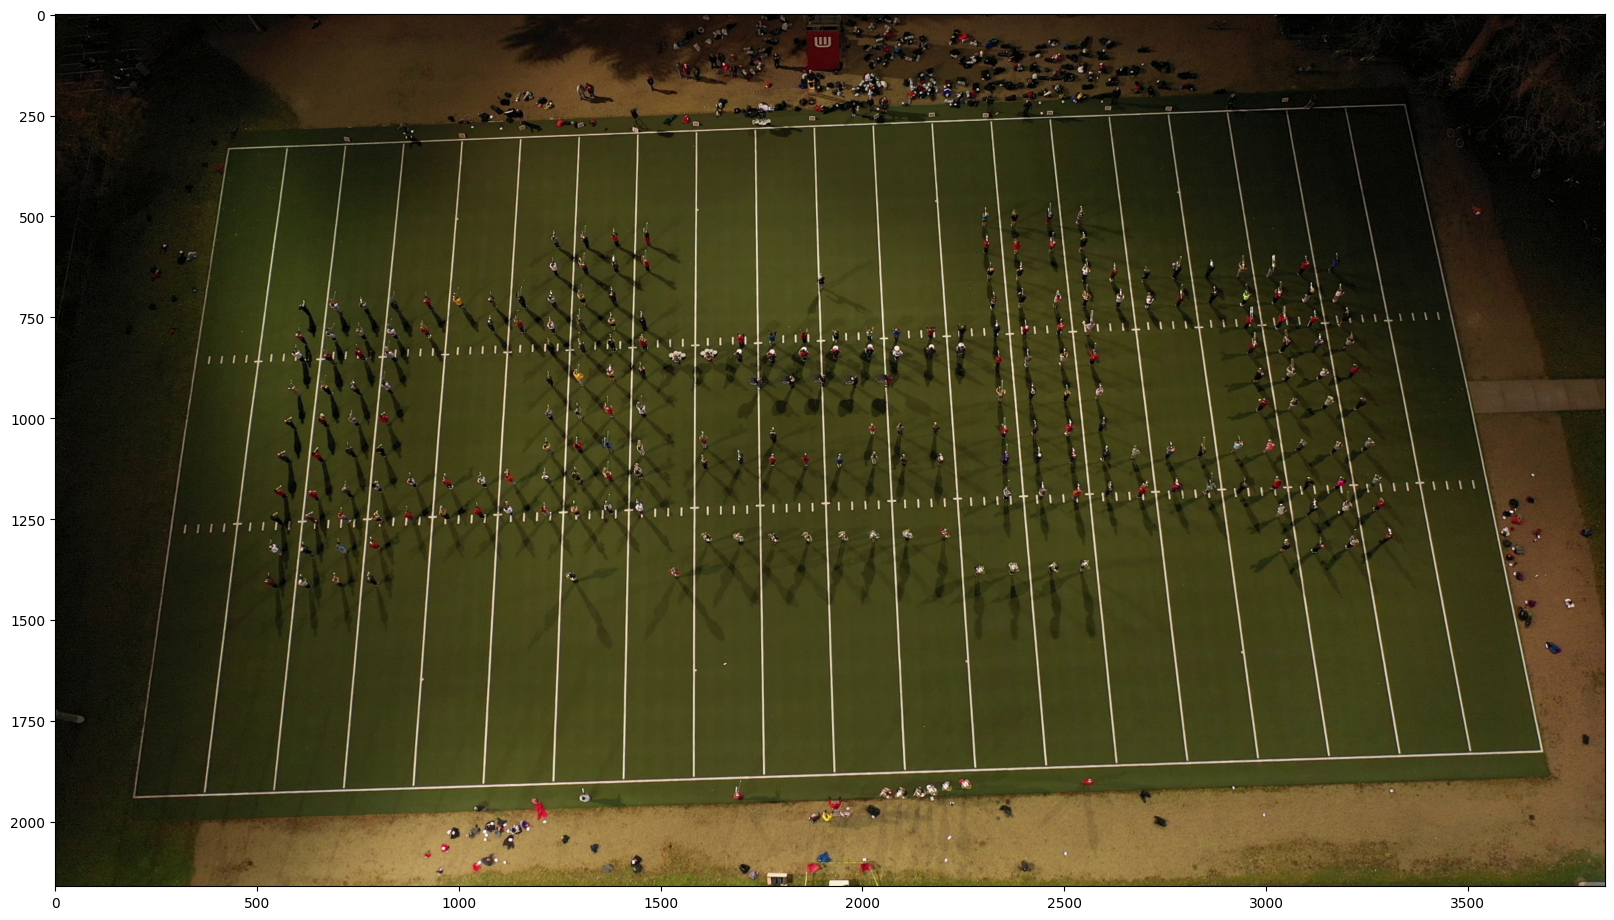

In [4]:
image = cv2.imread(os.path.join(frames_folder, video_name, 'frame_0001.jpg'))
show_image(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

### Edge detection

We do edge detection so that it will be easier for the segment-anything model to get the entire football field.

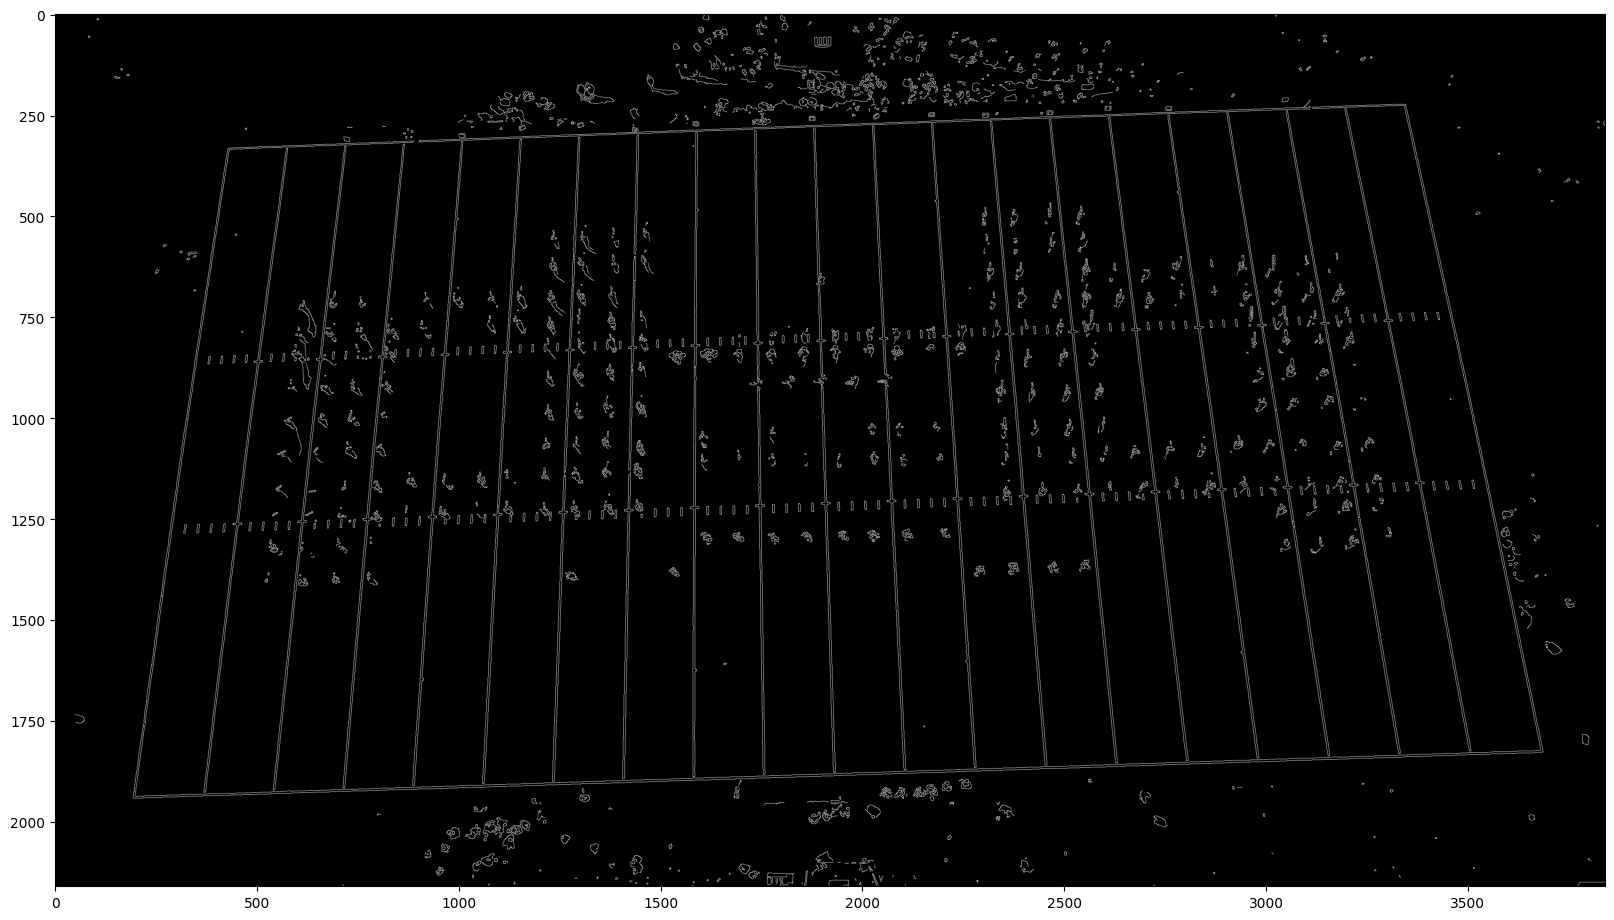

In [5]:
# TODO: adjust the threshold to get the best edge detection if the current result is suboptimal
threshold1 = 100
threshold2 = 200

img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
img_blur = cv2.GaussianBlur(img_gray, (3,3), 0) 
edges = cv2.Canny(img_blur, threshold1=threshold1, threshold2=threshold2)
edges = cv2.cvtColor(edges,cv2.COLOR_GRAY2RGB)
show_image(edges)

### Locate the football field

This can help the segment-anything model focus on our area of interest

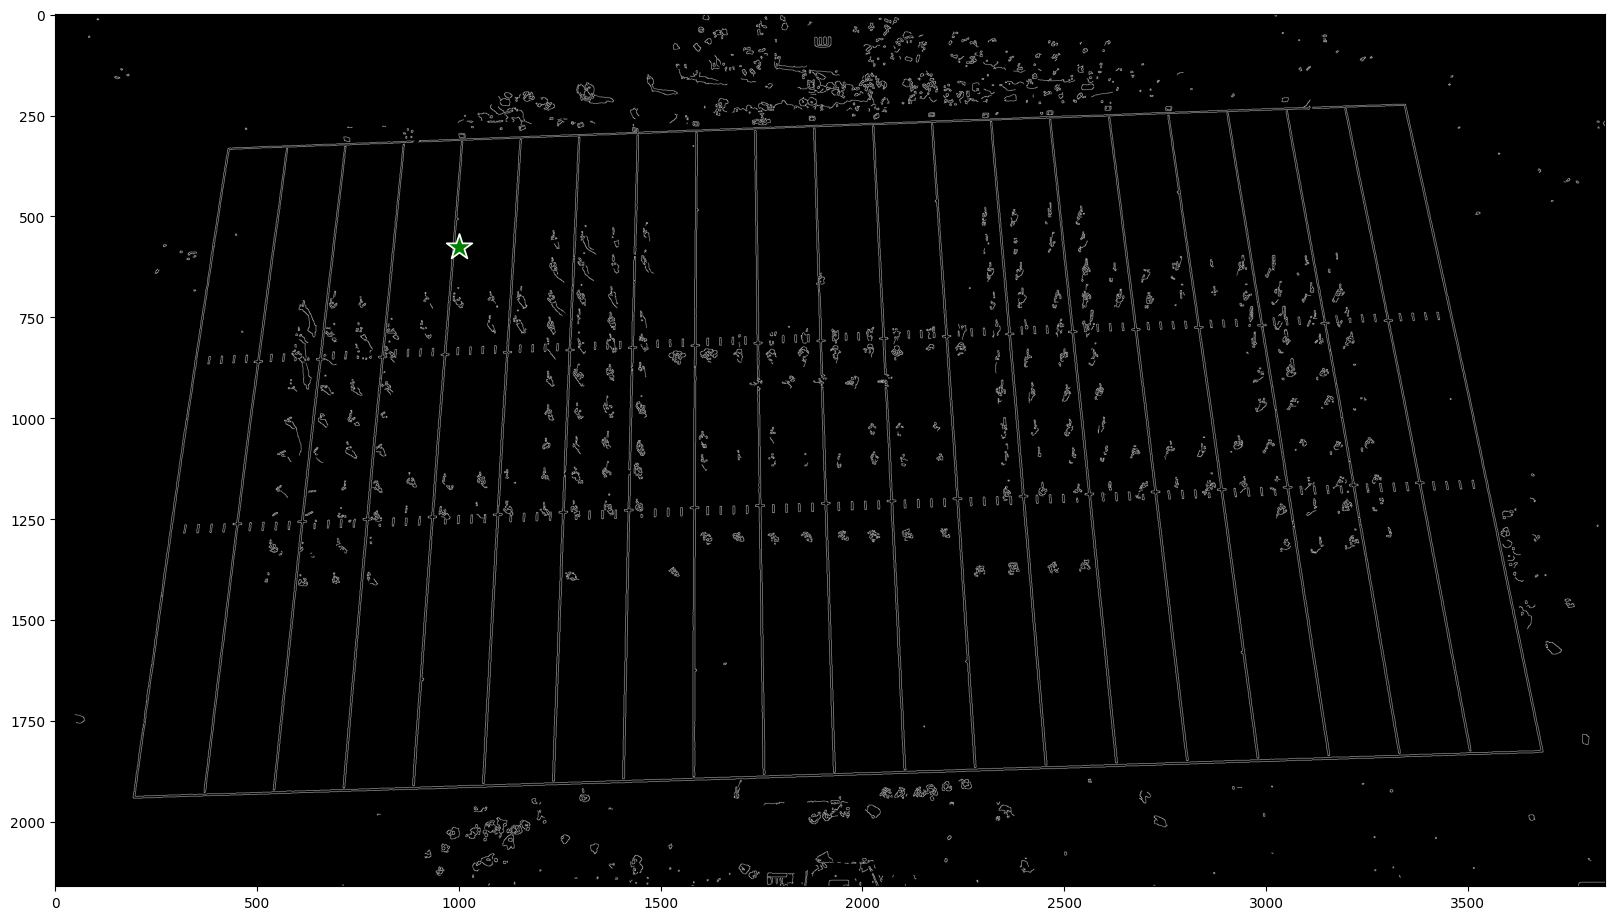

<Figure size 2000x2000 with 0 Axes>

In [6]:
# TODO: adjust the location of the label so that it is on the football field and is not too close to the edge
x, y = 1000, 575

input_point = np.array([[x, y]])
input_label = np.array([1])
show_image(edges)
show_points(input_point, input_label, plt.gca()) 

### Run the segment-anything model

In [7]:
# detect the area of interest (i.e. the football field) with segment-anything model
# TODO: download the pretrained model from "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth" and fill in the path
checkpoint = "/data/huanga/Synchrony/sam_vit_h_4b8939.pth"

sam = sam_model_registry["vit_h"](checkpoint=checkpoint)
predictor = SamPredictor(sam)
predictor.set_image(edges)
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

### Pick out the mask for the whole football field

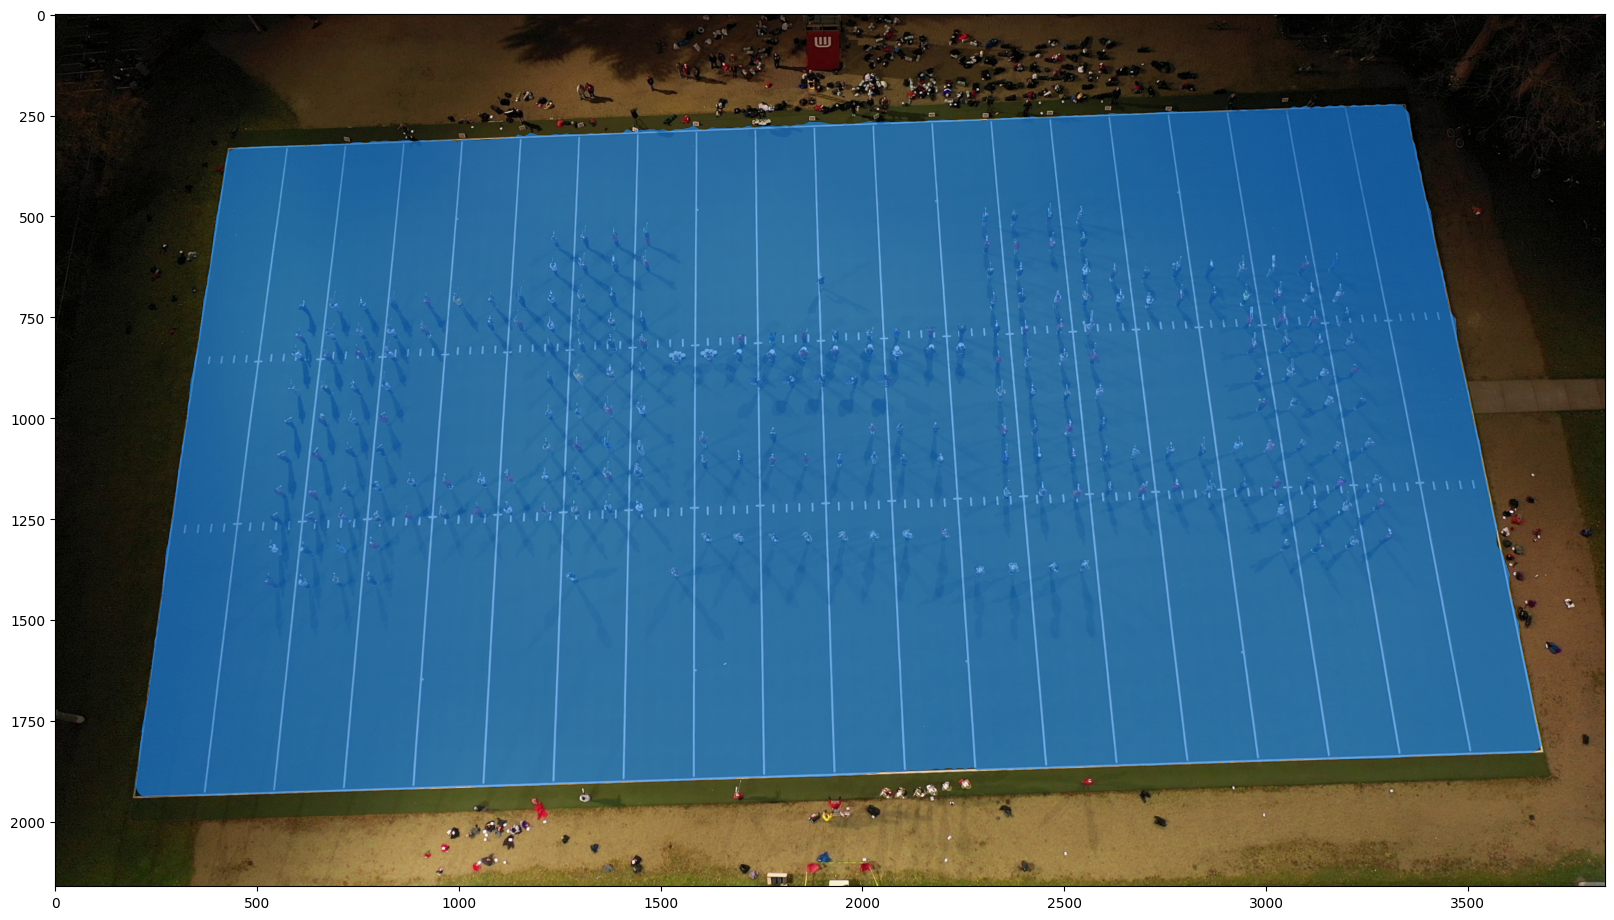

In [8]:
# TODO: adjust the mask_index to get the best mask if the current result is suboptimal.
# masks[0] usually corresponds to a smaller area instead of the whole football field
# masks[1] or masks[2] usually corresponds to the whole football field
mask_index = 2

show_image(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
show_mask(masks[mask_index], plt.gca()) # masks[0] usually corresponds to a smaller area instead of the whole football field

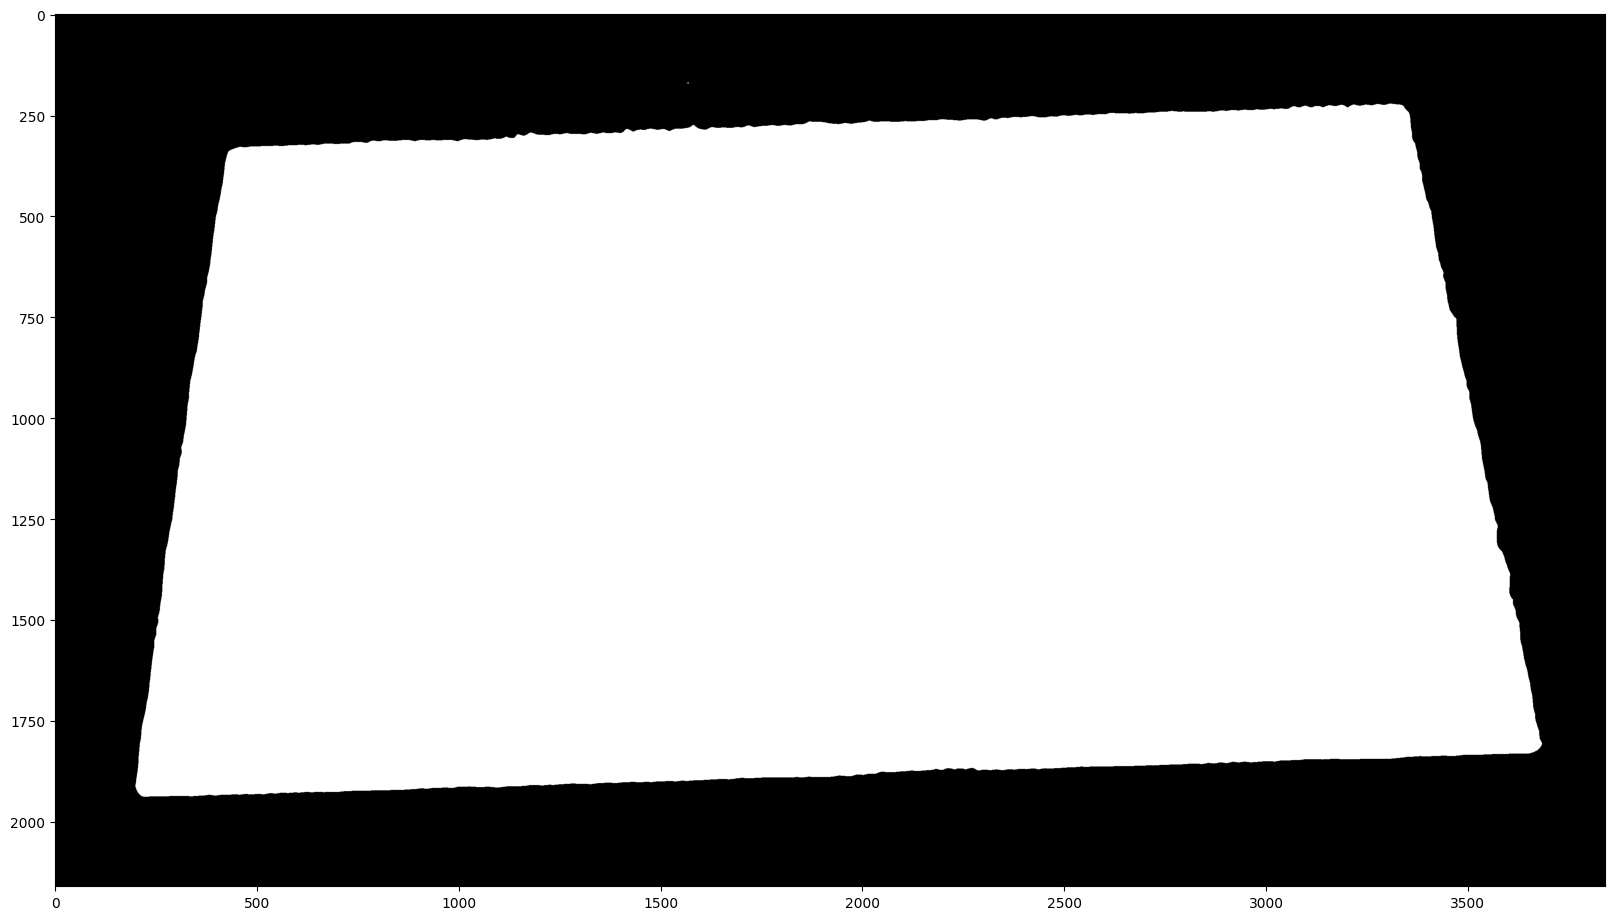

In [9]:
# Save the mask image for corner detection
white = np.array([255, 255, 255])
h, w = masks[mask_index].shape[-2:]
mask_image = masks[mask_index].reshape(h, w, 1) * white.reshape(1, 1, -1)
mask_image = cv2.cvtColor(cv2.convertScaleAbs(mask_image), cv2.COLOR_RGB2BGR)
show_image(mask_image)

### Get the potential corner of the images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


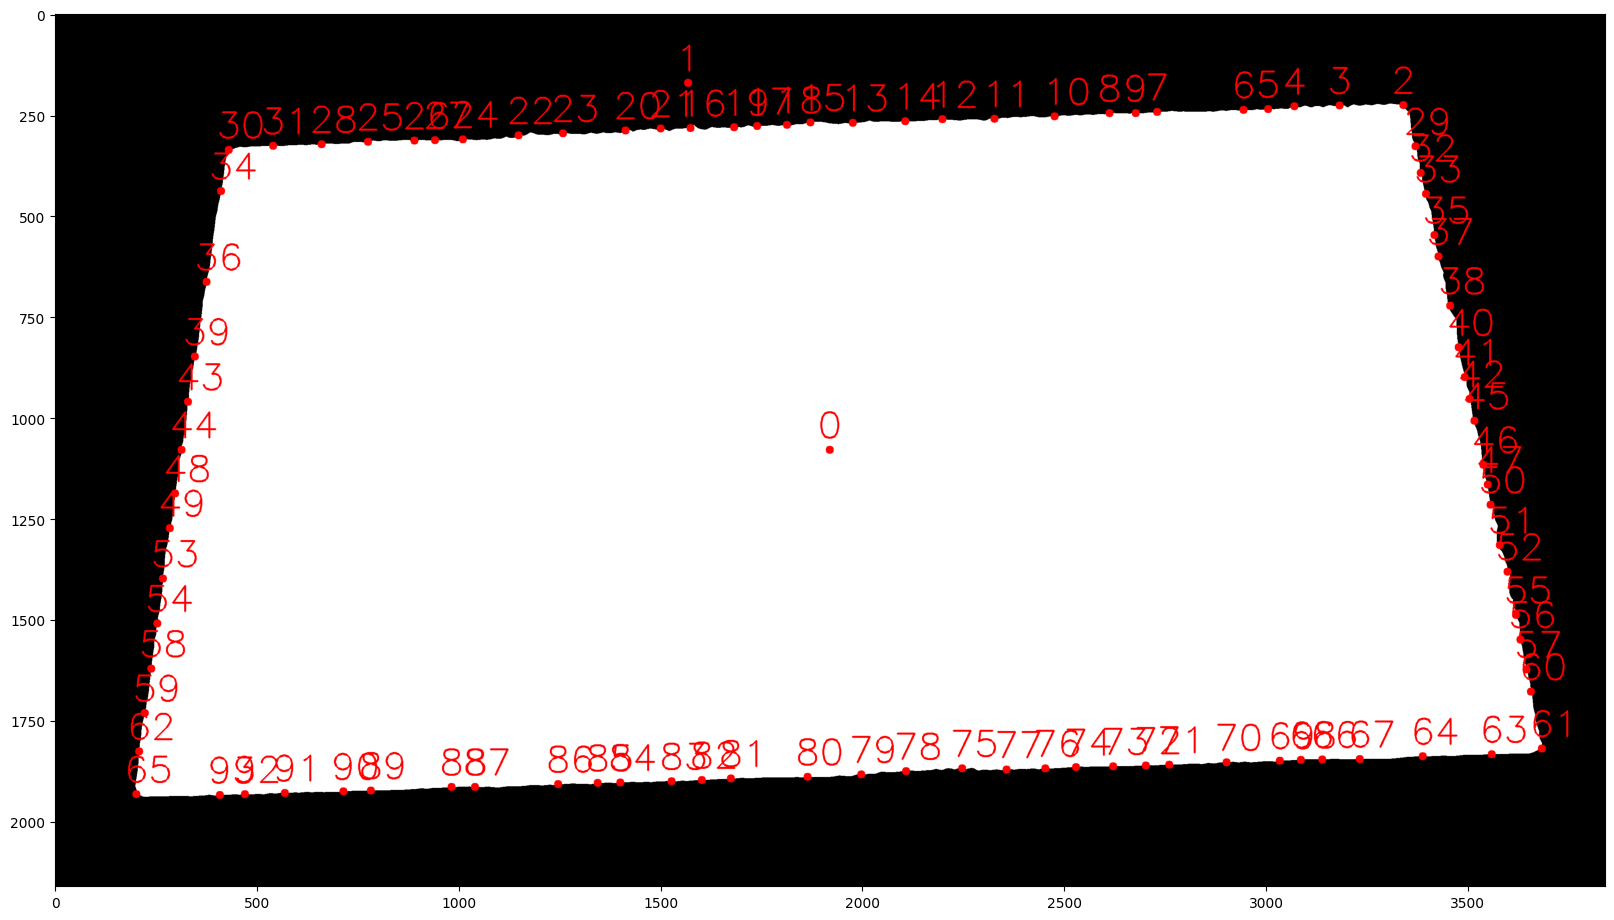

In [10]:
# TODO: experiment with different threshold values if the corner of the football field is not detected correctly
thres = 0.005

corner_image, points = get_corners(mask_image, thres)
show_image(corner_image)

In [11]:
# TODO: if the area of interest (i.e. the football field) has a missing corner
# 1. change missing_corner to true
# 2. manually add the point index of the other three corners into pts1, pts2, pts3
# 3. use find_intersection function to find the 4th corner (i.e. the missing corner)


missing_corner = False
if missing_corner:

    # TODO: manually fill in the point index of the other three corners
    pts1 = points[23]
    pts2 = points[11]
    pts3 = points[56]
    
    # TODO: manually fill in the two adjacent edges of the missing corner 
    edge_1 = (points[23], points[54])
    edge_2 = (points[56], points[87])
    
    # find the intersection of the two edges to get the missing corner
    pts4 = find_intersection(edge_1, edge_2)
    
    pts = [pts1, pts2, pts3, pts4]
    pts = np.array(pts)
else: 
    # the longest distance between two points is the diagonal of the rectangle
    d = np.sqrt(((points[:, None, :] - points) ** 2).sum(-1))
    diagnal_1, diagnal_2 = find_diagonal(d)
    pts = np.array([points[diagnal_1[0]], points[diagnal_1[1]], points[diagnal_2[0]], points[diagnal_2[1]]])

### Warp the first frame of this video

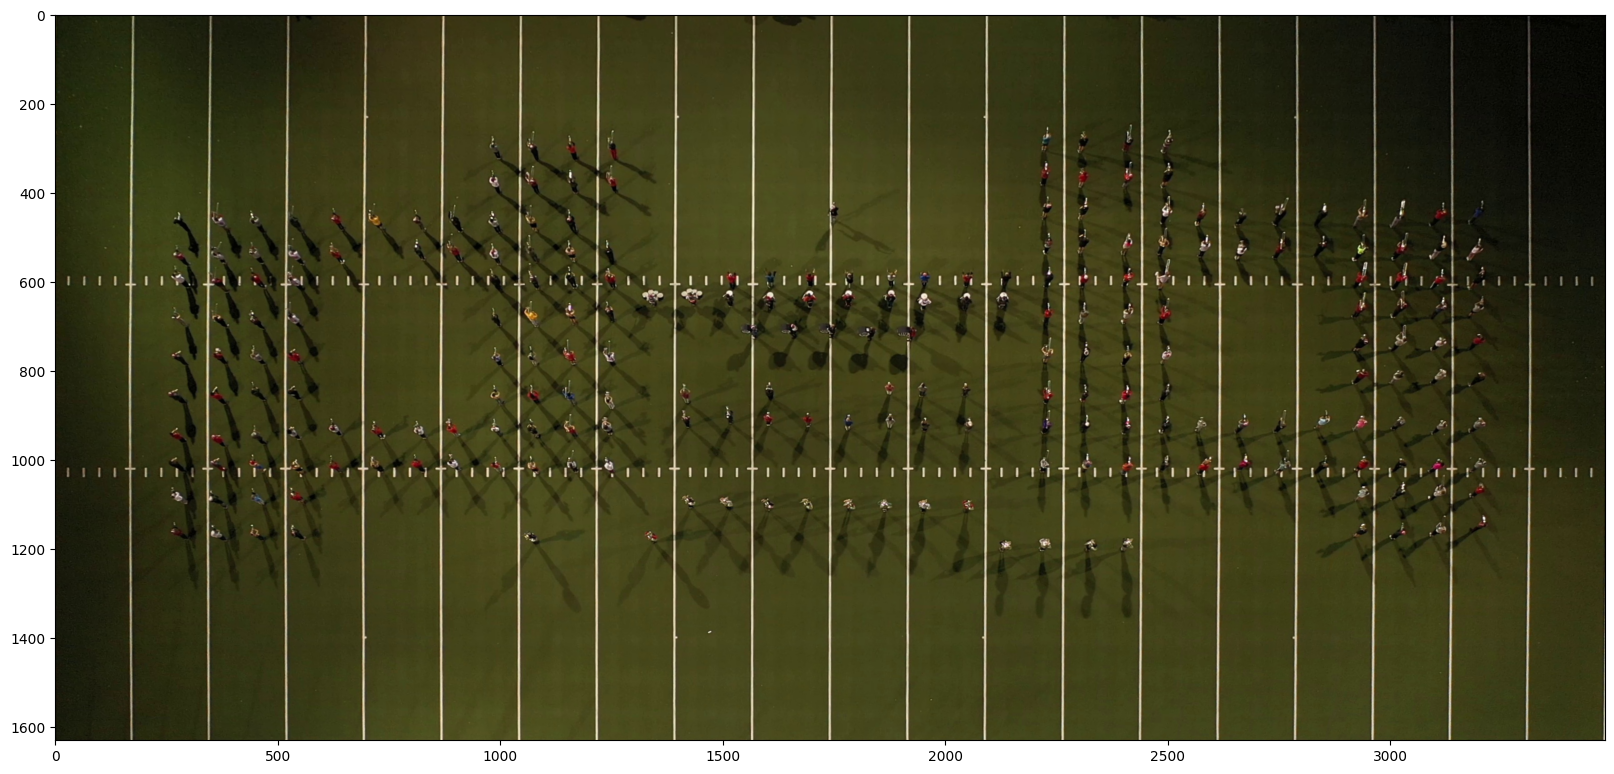

In [12]:
# sanity check on the first image
warped = four_point_transform(image, pts)
warped = cv2.cvtColor(warped, cv2.COLOR_RGB2BGR)
show_image(warped)

### Warp the rest of the frames of this video

WARNING: Here we assume that the area of interest does not shift across the frames in the same video (i.e. the camera did not move and the field did not move). This works for our use case but might not work for yours!

In [13]:
# wrap the football field in the rest of the frames
images = [ f for f in os.listdir(os.path.join(frames_folder, video_name)) if f.endswith(".jpg") ]
for image in images:
    img = cv2.imread(os.path.join(frames_folder, video_name, image))
    warped = four_point_transform(img, pts)
    cv2.imwrite(os.path.join(warped_frames_folder, video_name, image), warped)